(lgm1-notebook)=
# Curve di crescita latente 

Nel capitolo precedente, abbiamo esplorato come i modelli di Crescita Latente (LGM) possano essere correlati e confrontati con i modelli lineari ad effetti misti attraverso l'uso di dati simulati. In particolare, abbiamo osservato come sia possibile strutturare un modello LGM che incorpori un fattore latente per la variazione delle intercette individuali, il quale cattura le dinamiche del cambiamento delle medie nel tempo, e un secondo fattore latente che riflette le variazioni individuali nelle pendenze delle rette di regressione. 

Abbiamo esaminato in dettaglio il processo di definizione di questi fattori latenti, mettendo in atto una serie di vincoli sugli indicatori che identificano le variabili latenti. In particolare, abbiamo visto come l'applicazione dei vincoli 0, 1, 2, 3 alle saturazioni fattoriali per il fattore "pendenza" determini una relazione lineare tra la media del costrutto e il tempo. Questo approccio è particolarmente efficace quando le misurazioni del costrutto sono state effettuate a intervalli regolari.

In questo capitolo, ci dedicheremo all'approfondimento di questo argomento, spostando la nostra attenzione dall'ambito teorico e simulato all'analisi di un set di dati reali. Questo passaggio ci fornirà una visione più chiara e concreta di come questi modelli possano essere impiegati nell'analisi di dati longitudinali reali, con tutti le loro sfaccettature e sfide.

In [1]:
source("../_common.R")
suppressPackageStartupMessages({
    library("DT")
    library("kableExtra")
    library("lme4")
    library("emmeans")
})

## Una applicazione concreta

Esaminiamo l'adattamento di un modello LGM ad un campione di dati reali. In questo tutorial, considereremo il cambiamento nel rendimento in matematica dei bambini durante la scuola elementare e media utilizzando il set di dati NLSY-CYA {cite:p}`grimm2016growth`. Iniziamo a leggere i dati.

In [2]:
#set filepath for data file
filepath <- "https://raw.githubusercontent.com/LRI-2/Data/main/GrowthModeling/nlsy_math_wide_R.dat"
# read in the text data file using the url() function
dat <- read.table(
  file = url(filepath),
  na.strings = "."
) # indicates the missing data designator
# copy data with new name
nlsy_math_wide <- dat

# Give the variable names
names(nlsy_math_wide) <- c(
  "id", "female", "lb_wght", "anti_k1",
  "math2", "math3", "math4", "math5", "math6", "math7", "math8",
  "age2", "age3", "age4", "age5", "age6", "age7", "age8",
  "men2", "men3", "men4", "men5", "men6", "men7", "men8",
  "spring2", "spring3", "spring4", "spring5", "spring6", "spring7", "spring8",
  "anti2", "anti3", "anti4", "anti5", "anti6", "anti7", "anti8"
)

# view the first few observations (and columns) in the data set
head(nlsy_math_wide[, 1:11], 10)

,id,female,lb_wght,anti_k1,math2,math3,math4,math5,math6,math7,math8
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
1,201,1,0,0,NA,38,NA,55,NA,NA,NA
2,303,1,0,1,26,NA,NA,33,NA,NA,NA
3,2702,0,0,0,56,NA,58,NA,NA,NA,80
4,4303,1,0,0,NA,41,58,NA,NA,NA,NA
5,5002,0,0,4,NA,NA,46,NA,54,NA,66
6,5005,1,0,0,35,NA,50,NA,60,NA,59
7,5701,0,0,2,NA,62,61,NA,NA,NA,NA
8,6102,0,0,0,NA,NA,55,67,NA,81,NA
9,6801,1,0,0,NA,54,NA,62,NA,66,NA


Il nostro interesse specifico riguarda il cambiamento relativo alle misure ripetute di matematica, da `math2` a `math8`. Selezioniamo dunque le variabili di interesse.

In [3]:
nlsy_math_sub <- nlsy_math_wide |>
    dplyr::select("id", "math2", "math3", "math4", "math5", "math6", "math7", "math8")

Trasformiamo i dati in formato *long*.

In [4]:
nlsy_math_long <- reshape(
  data = nlsy_math_sub,
  timevar = c("grade"),
  idvar = "id",
  varying = c(
    "math2", "math3", "math4",
    "math5", "math6", "math7", "math8"
  ),
  direction = "long", sep = ""
)

Ordiniamo i dati in base alle variabili `id` e `grade`.

In [5]:
nlsy_math_long <- nlsy_math_long[order(nlsy_math_long$id, nlsy_math_long$grade), ]

Rimuoviamo gli NA dalla variabile `math` per potere generare il grafico con le traiettorie individuali di sviluppo.

In [6]:
nlsy_math_long <- nlsy_math_long[which(is.na(nlsy_math_long$math) == FALSE), ]

Esaminiamo i dati grezzi.

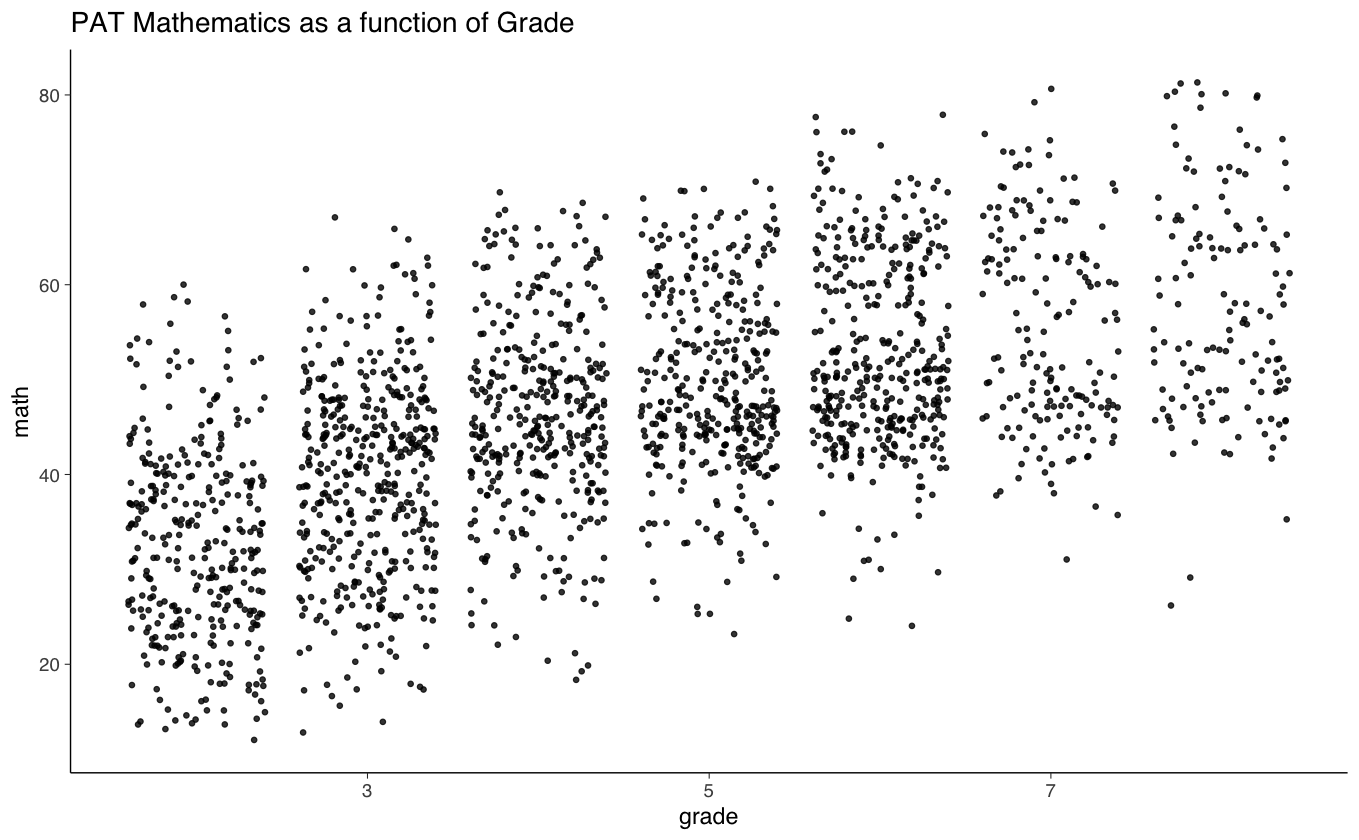

In [7]:
nlsy_math_long |>
  ggplot(aes(x = grade, y = math)) +
  geom_point(
    size = 1.2,
    alpha = .8,
    # to add some random noise for plotting purposes
    position = "jitter"
  ) +
  labs(title = "PAT Mathematics as a function of Grade")


Aggiungiamo al grafico le retta dei minimi quadrati calcolata su tutti i dati (ignorando il ragruppamento dei dati in funzione dei partecipanti). 

`geom_smooth()` using formula = 'y ~ x'


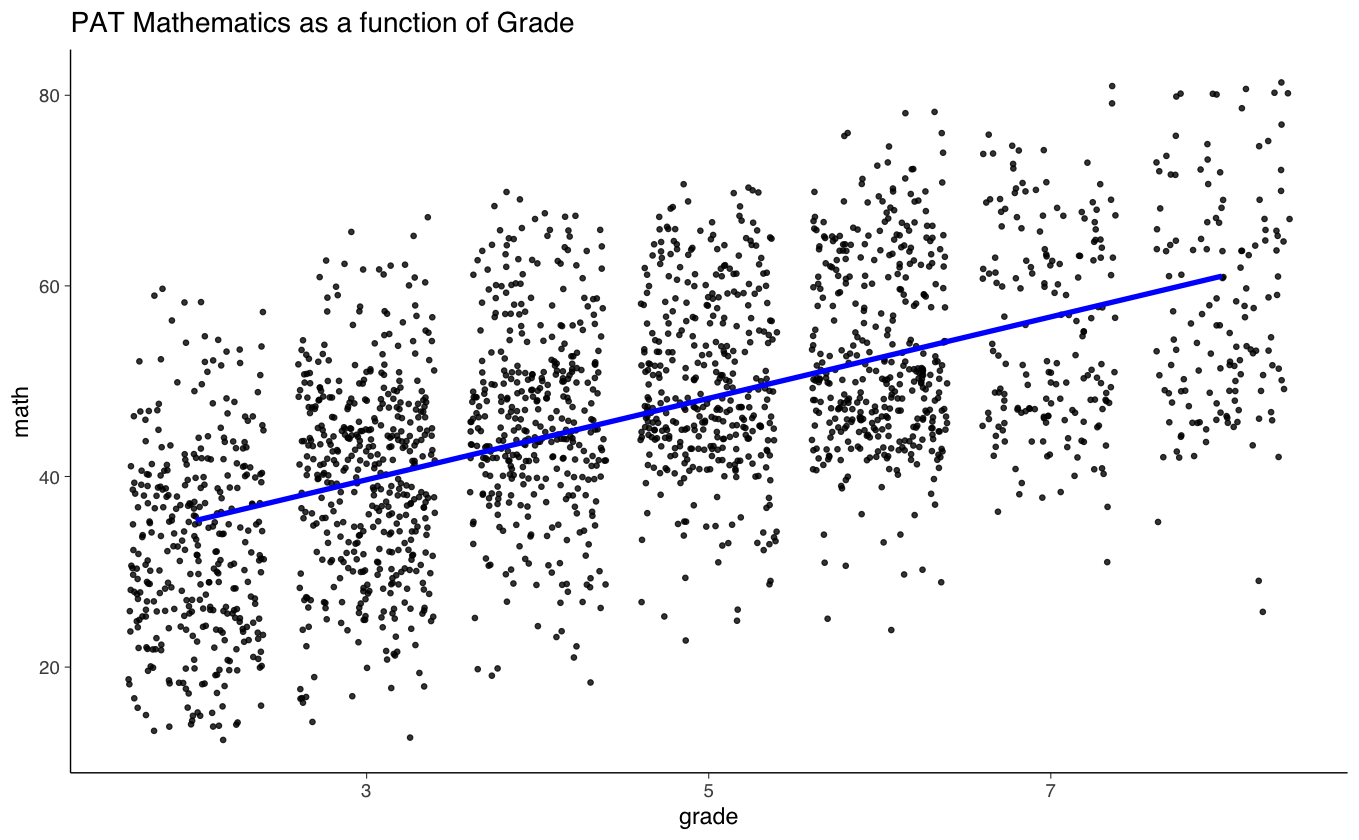

In [8]:
nlsy_math_long |>
    ggplot(aes(x = grade, y = math)) +
    geom_point(
        size = 1.2,
        alpha = .8,
        # to add some random noise for plotting purposes
        position = "jitter"
    ) +
    geom_smooth(
        method = lm,
        se = FALSE,
        col = "blue",
        linewidth = 1.5,
        alpha = .8
    ) + # to add regression line
    labs(title = "PAT Mathematics as a function of Grade")

Esaminiamo le traiettorie di cambiamento intra-individuale.

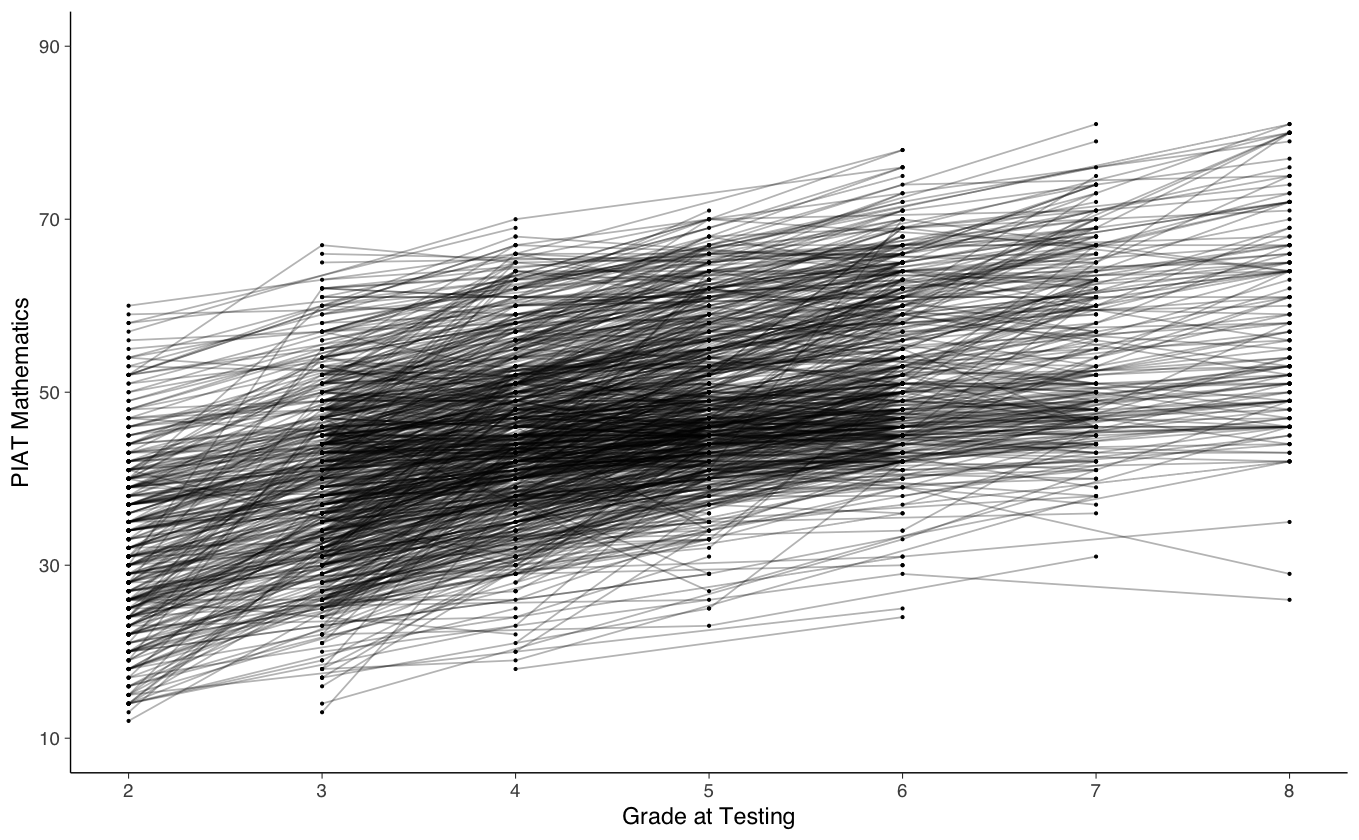

In [9]:
# intraindividual change trajetories
nlsy_math_long |>
  ggplot(
    aes(x = grade, y = math, group = id)
  ) + # setting variables
  geom_point(size = .5) + # adding points to plot
  geom_line(alpha = 0.3) + # adding lines to plot
  # setting the x-axis with breaks and labels
  scale_x_continuous(
    limits = c(2, 8),
    breaks = c(2, 3, 4, 5, 6, 7, 8),
    name = "Grade at Testing"
  ) +
  # setting the y-axis with limits breaks and labels
  scale_y_continuous(
    limits = c(10, 90),
    breaks = c(10, 30, 50, 70, 90),
    name = "PIAT Mathematics"
  )


## Modello di assenza di crescita

Dall'analisi dei grafici precedenti, si osserva che i punteggi di matematica mostrano un incremento sistematico nel tempo. Per iniziare l'analisi, adotteremo un modello di assenza di crescita come benchmark di base per il confronto con modelli più complessi successivi.

In questo modello si assume che i punteggi di matematica degli studenti rimangano invariati nel corso del tempo. Esso mira a stimare, per ogni studente, il "valore vero" dei loro punteggi in matematica, senza prendere in considerazione eventuali variazioni nel tempo. Poiché non contempla la dinamica temporale dei punteggi, questo modello rappresenta una situazione di stallo o assenza di sviluppo, risultando spesso di limitato interesse e pertanto generalmente non viene adottato in analisi più approfondite.

Il modello di assenza della crescita è caratterizzato dalla presenza di una variabile latente e di un'intercetta, la quale rappresenta un livello medio di performance che si mantiene costante nel tempo. Questa configurazione del modello permette di stabilire un punto di partenza per comprendere se e in che misura i punteggi di matematica variano effettivamente nel corso del tempo, quando confrontati con modelli che considerano la crescita o l'evoluzione dei punteggi.

Per definire il modello di assenza di crescita, utilizziamo la seguente sintassi di lavaan.

In [10]:
ng_math_lavaan_model <- ' 
  # latent variable definitions
      #intercept
      eta_1 =~ 1*math2
      eta_1 =~ 1*math3
      eta_1 =~ 1*math4
      eta_1 =~ 1*math5
      eta_1 =~ 1*math6
      eta_1 =~ 1*math7
      eta_1 =~ 1*math8

  # factor variances
      eta_1 ~~ eta_1

  # covariances among factors 
      #none (only 1 factor)

  # factor means 
      eta_1 ~ start(30)*1

  # manifest variances (made equivalent by naming theta)
      math2 ~~ theta*math2
      math3 ~~ theta*math3
      math4 ~~ theta*math4
      math5 ~~ theta*math5
      math6 ~~ theta*math6
      math7 ~~ theta*math7
      math8 ~~ theta*math8
  # manifest means (fixed at zero)
      math2 ~ 0*1
      math3 ~ 0*1
      math4 ~ 0*1
      math5 ~ 0*1
      math6 ~ 0*1
      math7 ~ 0*1
      math8 ~ 0*1
' #end of model definition

Adattiamo il modello ai dati.

In [11]:
ng_math_lavaan_fit <- sem(ng_math_lavaan_model,
  data = nlsy_math_wide,
  meanstructure = TRUE,
  estimator = "ML",
  missing = "fiml"
)

Warning message in lav_data_full(data = data, group = group, cluster = cluster, :
“lavaan WARNING: some cases are empty and will be ignored:
  741”


Warning message in lav_data_full(data = data, group = group, cluster = cluster, :
“lavaan WARNING:
    due to missing values, some pairwise combinations have less than
    10% coverage; use lavInspect(fit, "coverage") to investigate.”


Warning message in lav_mvnorm_missing_h1_estimate_moments(Y = X[[g]], wt = WT[[g]], :
“lavaan WARNING:
    Maximum number of iterations reached when computing the sample
    moments using EM; use the em.h1.iter.max= argument to increase the
    number of iterations”


Nel codice fornito, l'opzione `missing = "fiml"` utilizzata nella funzione `sem()` specifica il metodo "Full Information Maximum Likelihood" (FIML) per gestire i dati mancanti nel dataset. FIML è un approccio sofisticato per la gestione dei dati mancanti in analisi statistiche complesse come i modelli SEM. A differenza di metodi più semplici come l'eliminazione lista per lista o l'imputazione media, FIML utilizza tutte le informazioni disponibili nel dataset, inclusi i pattern dei dati mancanti, per produrre stime dei parametri. Questo metodo è particolarmente utile quando si lavora con dataset longitudinali o complessi dove i dati mancanti sono comuni. FIML è considerato un approccio più accurato e meno distorto rispetto ad altri metodi, in quanto non si limita a utilizzare solo i casi completi, ma incorpora l'intero insieme di dati disponibili, comprese le osservazioni parziali.

Esaminiamo la soluzione.

In [12]:
summary(ng_math_lavaan_fit, fit.measures = TRUE, standardized = TRUE) |>
    print()

lavaan 0.6.17 ended normally after 18 iterations

  Estimator                                         ML
  Optimization method                           NLMINB
  Number of model parameters                         9
  Number of equality constraints                     6

                                                  Used       Total
  Number of observations                           932         933
  Number of missing patterns                        60            

Model Test User Model:
                                                      
  Test statistic                              1759.002
  Degrees of freedom                                32
  P-value (Chi-square)                           0.000

Model Test Baseline Model:

  Test statistic                               862.334
  Degrees of freedom                                21
  P-value                                        0.000

User Model versus Baseline Model:

  Comparative Fit Index (CFI)                    0.000

Generiamo il diagramma di percorso.

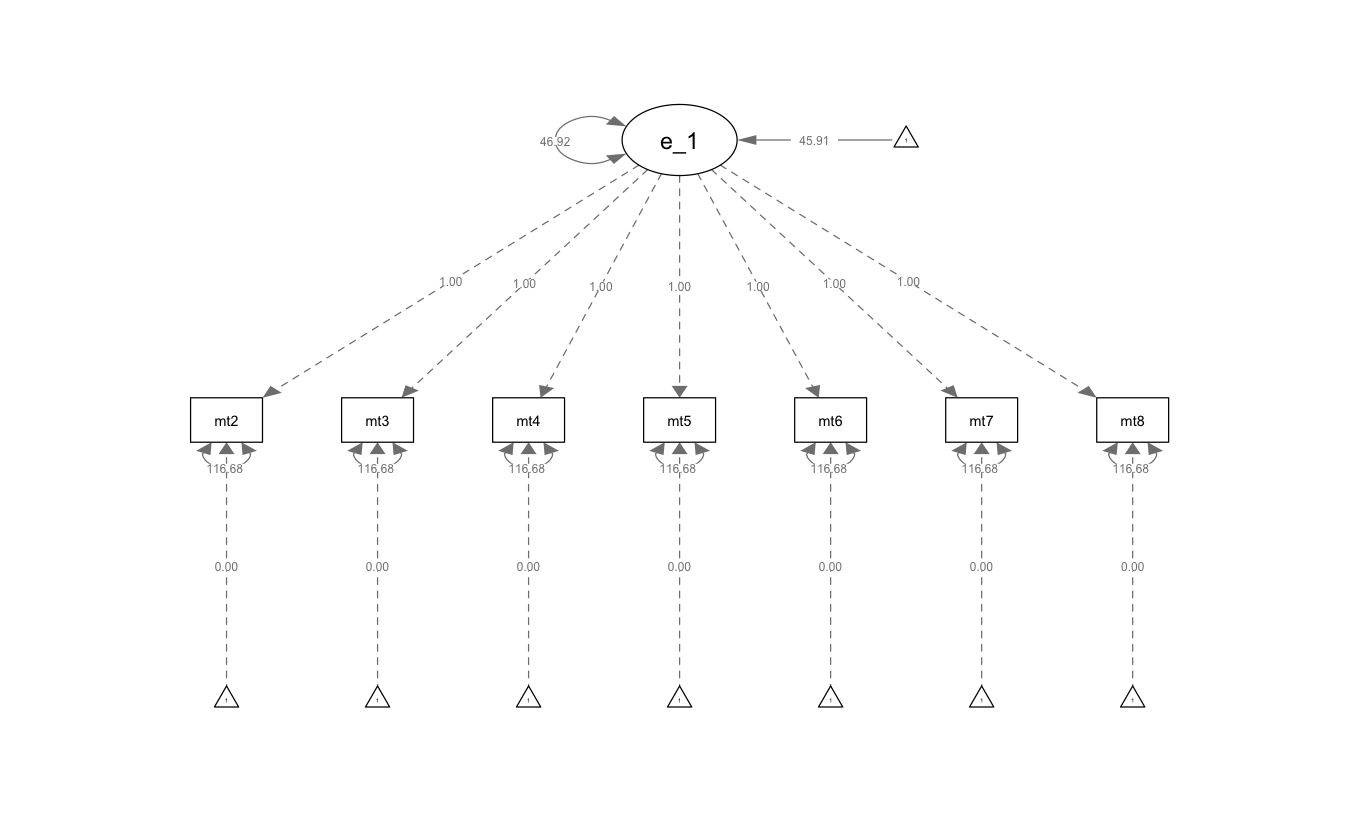

In [13]:
semPaths(ng_math_lavaan_fit, what = "path", whatLabels = "par")

Calcoliamo le traiettorie predette.

In [14]:
#obtaining predicted factor scores for individuals
nlsy_math_predicted <- as.data.frame(cbind(nlsy_math_wide$id,lavPredict(ng_math_lavaan_fit)))

#naming columns
names(nlsy_math_predicted) <- c("id", "eta_1")

#looking at data
head(nlsy_math_predicted) 

,id,eta_1
,<dbl>,<dbl>
1,201,46.17558
2,303,38.59816
3,2702,56.16725
4,4303,47.51278
5,5002,51.06429
6,5005,49.05038


Warning message:
“Removed 7 rows containing missing values (`geom_line()`).”


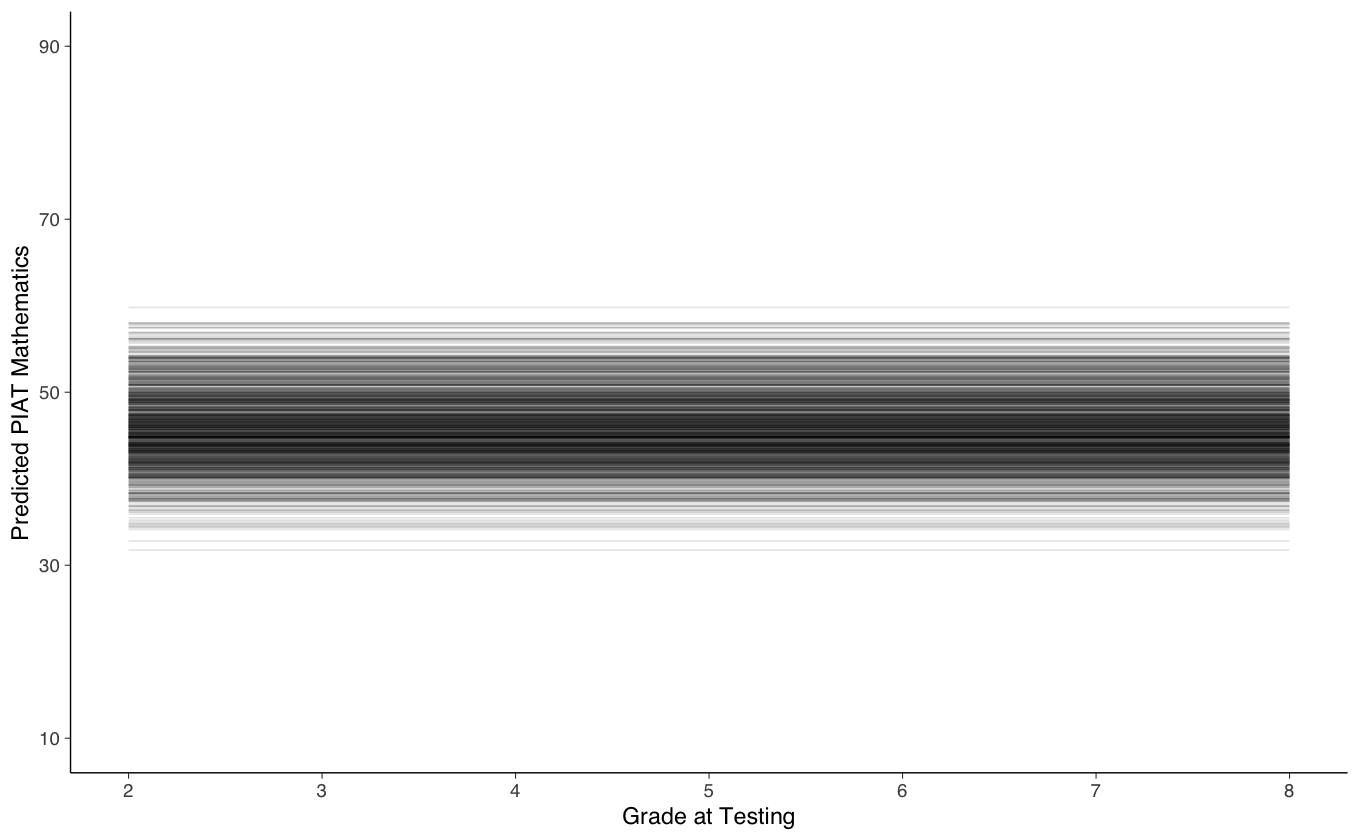

In [15]:
# calculating implied manifest scores
nlsy_math_predicted$math2 <- 1 * nlsy_math_predicted$eta_1
nlsy_math_predicted$math3 <- 1 * nlsy_math_predicted$eta_1
nlsy_math_predicted$math4 <- 1 * nlsy_math_predicted$eta_1
nlsy_math_predicted$math5 <- 1 * nlsy_math_predicted$eta_1
nlsy_math_predicted$math6 <- 1 * nlsy_math_predicted$eta_1
nlsy_math_predicted$math7 <- 1 * nlsy_math_predicted$eta_1
nlsy_math_predicted$math8 <- 1 * nlsy_math_predicted$eta_1

# reshaping wide to long
nlsy_math_predicted_long <- reshape(
  data = nlsy_math_predicted,
  timevar = c("grade"),
  idvar = "id",
  varying = c(
    "math2", "math3", "math4",
    "math5", "math6", "math7", "math8"
  ),
  direction = "long", sep = ""
)
# sorting for easy viewing
# order by id and time
nlsy_math_predicted_long <- nlsy_math_predicted_long[order(nlsy_math_predicted_long$id, nlsy_math_predicted_long$grade), ]

# intraindividual change trajetories
ggplot(
  data = nlsy_math_predicted_long, # data set
  aes(x = grade, y = math, group = id)
) + # setting variables
  # geom_point(size=.5) + #adding points to plot
  geom_line(alpha = 0.1) + # adding lines to plot
  # setting the x-axis with breaks and labels
  scale_x_continuous(
    limits = c(2, 8),
    breaks = c(2, 3, 4, 5, 6, 7, 8),
    name = "Grade at Testing"
  ) +
  # setting the y-axis with limits breaks and labels
  scale_y_continuous(
    limits = c(10, 90),
    breaks = c(10, 30, 50, 70, 90),
    name = "Predicted PIAT Mathematics"
  )

Dal grafico risulta evidente che il modello impiegato genera una serie di linee orizzontali, ognuna rappresentante la traiettoria statica dell'abilità matematica per ogni individuo. In questo modello, l'intercetta associata a ciascuna di queste linee orizzontali corrisponde al "valore vero" dell'abilità matematica di ogni bambino. Conformemente alle ipotesi del modello, questo valore si mantiene invariato nel corso del tempo, suggerendo che, secondo il modello, l'abilità matematica di ciascun individuo non subisce variazioni o sviluppi significativi nel periodo osservato.

## Modello di crescita lineare

Nella discussione dei modelli di crescita, il modello di assenza di crescita viene sempre seguito dall'esame del modello di crescita lineare. Infatti, i modelli di crescita lineare rappresentano spesso il punto di partenza quando si cerca di comprendere il cambiamento all'interno dell'individuo. Successivamente, possono essere considerati anche modelli di crescita non lineare. Procediamo dunque all'implementazione di un modello di crescita latente lineare.

In [16]:
lg_math_lavaan_model <- '
  # latent variable definitions
      #intercept (note intercept is a reserved term)
      eta_1 =~ 1*math2
      eta_1 =~ 1*math3
      eta_1 =~ 1*math4
      eta_1 =~ 1*math5
      eta_1 =~ 1*math6
      eta_1 =~ 1*math7
      eta_1 =~ 1*math8

      #linear slope 
      eta_2 =~ 0*math2
      eta_2 =~ 1*math3
      eta_2 =~ 2*math4
      eta_2 =~ 3*math5
      eta_2 =~ 4*math6
      eta_2 =~ 5*math7
      eta_2 =~ 6*math8

  # factor variances
      eta_1 ~~ eta_1
      eta_2 ~~ eta_2

  # covariances among factors 
      eta_1 ~~ eta_2

  # factor means 
      eta_1 ~ 1
      eta_2 ~ 1

  # manifest variances (made equivalent by naming theta)
      math2 ~~ theta*math2
      math3 ~~ theta*math3
      math4 ~~ theta*math4
      math5 ~~ theta*math5
      math6 ~~ theta*math6
      math7 ~~ theta*math7
      math8 ~~ theta*math8
  # manifest means (fixed at zero)
      math2 ~ 0*1
      math3 ~ 0*1
      math4 ~ 0*1
      math5 ~ 0*1
      math6 ~ 0*1
      math7 ~ 0*1
      math8 ~ 0*1
' #end of model definition

Adattiamo il modello ai dati.

In [17]:
lg_math_lavaan_fit <- sem(lg_math_lavaan_model,
  data = nlsy_math_wide,
  meanstructure = TRUE,
  estimator = "ML",
  missing = "fiml"
)

Warning message in lav_data_full(data = data, group = group, cluster = cluster, :
“lavaan WARNING: some cases are empty and will be ignored:
  741”


Warning message in lav_data_full(data = data, group = group, cluster = cluster, :
“lavaan WARNING:
    due to missing values, some pairwise combinations have less than
    10% coverage; use lavInspect(fit, "coverage") to investigate.”


Warning message in lav_mvnorm_missing_h1_estimate_moments(Y = X[[g]], wt = WT[[g]], :
“lavaan WARNING:
    Maximum number of iterations reached when computing the sample
    moments using EM; use the em.h1.iter.max= argument to increase the
    number of iterations”


Esaminiamo il risultato ottenuto.

In [18]:
summary(lg_math_lavaan_fit, fit.measures = TRUE, standardized = TRUE) |>
    print()

lavaan 0.6.17 ended normally after 38 iterations

  Estimator                                         ML
  Optimization method                           NLMINB
  Number of model parameters                        12
  Number of equality constraints                     6

                                                  Used       Total
  Number of observations                           932         933
  Number of missing patterns                        60            

Model Test User Model:
                                                      
  Test statistic                               204.484
  Degrees of freedom                                29
  P-value (Chi-square)                           0.000

Model Test Baseline Model:

  Test statistic                               862.334
  Degrees of freedom                                21
  P-value                                        0.000

User Model versus Baseline Model:

  Comparative Fit Index (CFI)                    0.791

In [19]:
print(fitMeasures(lg_math_lavaan_fit, c("chisq", "df", "pvalue", "cfi", "rmsea")))

  chisq      df  pvalue     cfi   rmsea 
204.484  29.000   0.000   0.791   0.081 


Generiamo un diagramma di percorso.

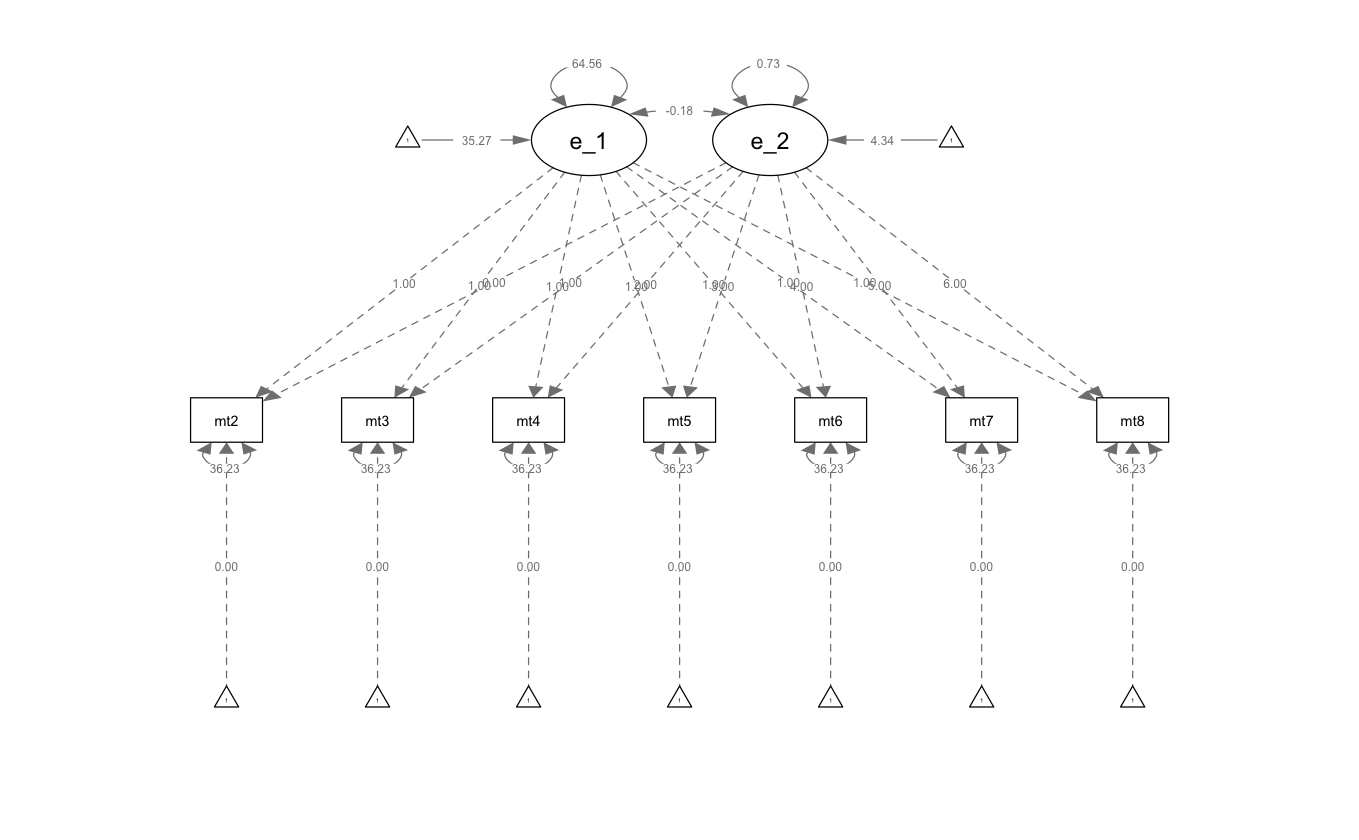

In [20]:
semPaths(lg_math_lavaan_fit, what = "path", whatLabels = "par")

Esaminiamo le traiettorie di crescita.

In [21]:
nlsy_math_predicted <- as.data.frame(
    cbind(nlsy_math_wide$id, lavPredict(lg_math_lavaan_fit))
)

#naming columns
names(nlsy_math_predicted) <- c("id", "eta_1", "eta_2")

head(nlsy_math_predicted)

,id,eta_1,eta_2
,<dbl>,<dbl>,<dbl>
1,201,36.94675,4.534084
2,303,26.03589,4.050780
3,2702,49.70187,4.594149
4,4303,41.04200,4.548064
5,5002,37.01240,4.496746
6,5005,37.68809,4.324198


In [22]:
#calculating implied manifest scores
nlsy_math_predicted$math2 <- 1 * nlsy_math_predicted$eta_1 + 0 * nlsy_math_predicted$eta_2
nlsy_math_predicted$math3 <- 1 * nlsy_math_predicted$eta_1 + 1 * nlsy_math_predicted$eta_2
nlsy_math_predicted$math4 <- 1 * nlsy_math_predicted$eta_1 + 2 * nlsy_math_predicted$eta_2
nlsy_math_predicted$math5 <- 1 * nlsy_math_predicted$eta_1 + 3 * nlsy_math_predicted$eta_2
nlsy_math_predicted$math6 <- 1 * nlsy_math_predicted$eta_1 + 4 * nlsy_math_predicted$eta_2
nlsy_math_predicted$math7 <- 1 * nlsy_math_predicted$eta_1 + 5 * nlsy_math_predicted$eta_2
nlsy_math_predicted$math8 <- 1 * nlsy_math_predicted$eta_1 + 6 * nlsy_math_predicted$eta_2

In [23]:
# reshaping wide to long
nlsy_math_predicted_long <- reshape(
  data = nlsy_math_predicted,
  timevar = c("grade"),
  idvar = "id",
  varying = c(
    "math2", "math3", "math4", "math5", "math6", "math7", "math8"
  ),
  direction = "long", sep = ""
)

In [24]:
head(nlsy_math_predicted_long)

,id,eta_1,eta_2,grade,math
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
201.2,201,36.94675,4.534084,2,36.94675
303.2,303,26.03589,4.050780,2,26.03589
2702.2,2702,49.70187,4.594149,2,49.70187
4303.2,4303,41.04200,4.548064,2,41.04200
5002.2,5002,37.01240,4.496746,2,37.01240
5005.2,5005,37.68809,4.324198,2,37.68809


In [25]:
# sorting for easy viewing
# order by id and time
nlsy_math_predicted_long <-
  nlsy_math_predicted_long[order(nlsy_math_predicted_long$id, nlsy_math_predicted_long$grade), ]

In [26]:
head(nlsy_math_predicted_long)

,id,eta_1,eta_2,grade,math
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
201.2,201,36.94675,4.534084,2,36.94675
201.3,201,36.94675,4.534084,3,41.48083
201.4,201,36.94675,4.534084,4,46.01492
201.5,201,36.94675,4.534084,5,50.54900
201.6,201,36.94675,4.534084,6,55.08309
201.7,201,36.94675,4.534084,7,59.61717


Warning message:
“Removed 7 rows containing missing values (`geom_line()`).”


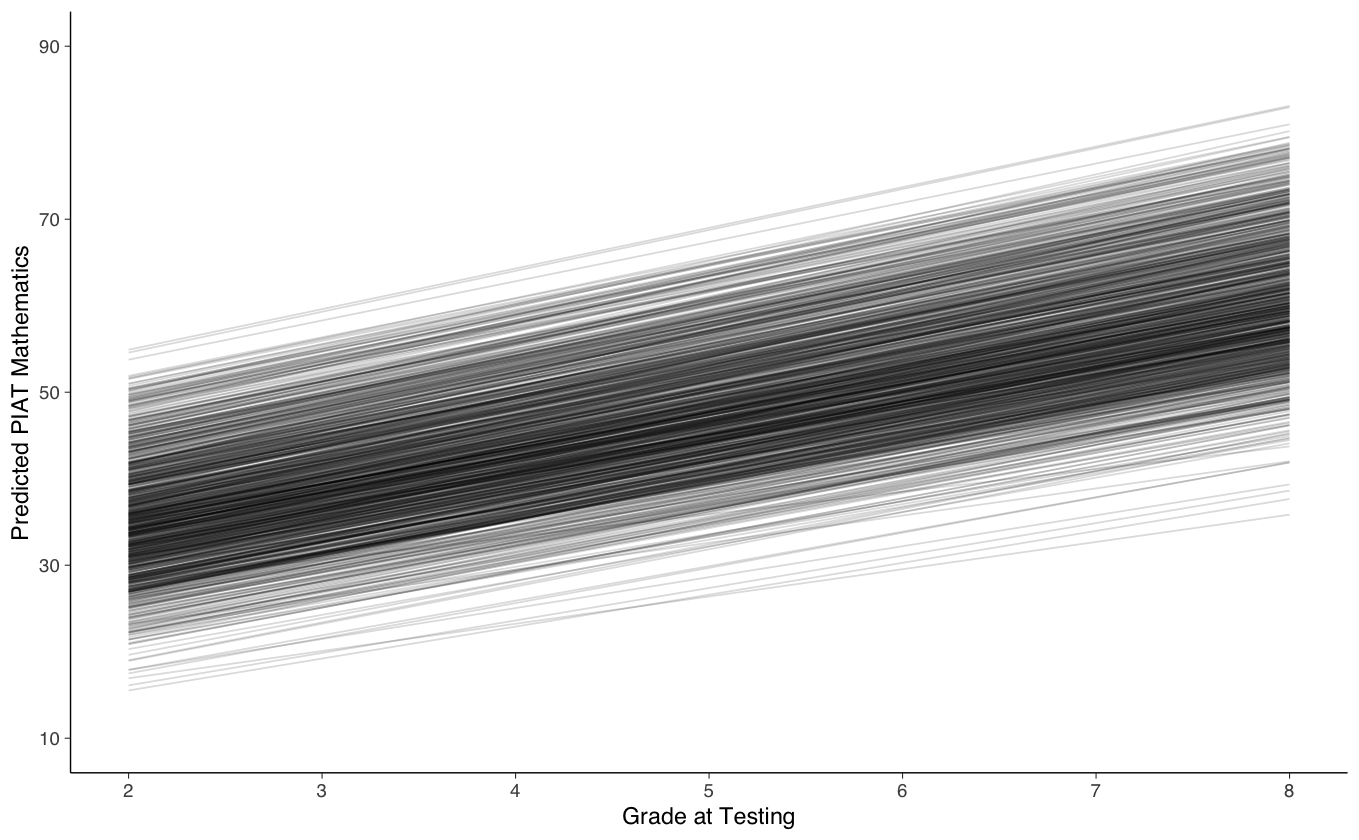

In [27]:
ggplot(
  data = nlsy_math_predicted_long, # data set
  aes(x = grade, y = math, group = id)
) + # setting variables
  # geom_point(size=.5) + #adding points to plot
  geom_line(alpha = 0.15) + # adding lines to plot
  # setting the x-axis with breaks and labels
  scale_x_continuous(
    limits = c(2, 8),
    breaks = c(2, 3, 4, 5, 6, 7, 8),
    name = "Grade at Testing"
  ) +
  # setting the y-axis with limits breaks and labels
  scale_y_continuous(
    limits = c(10, 90),
    breaks = c(10, 30, 50, 70, 90),
    name = "Predicted PIAT Mathematics"
  )

Il modello di crescita latente lineare descrive la traiettoria di sviluppo di ogni bambino attraverso una linea retta, mettendo in luce le variazioni individuali nelle competenze matematiche nel corso del tempo. Il grafico illustra che, per ciascun bambino, si registra un incremento "reale" di circa 5 punti nell'abilità matematica per ogni anno scolastico. Questo modello, quindi, non solo traccia la progressione lineare delle competenze matematiche, ma rivela anche un pattern di crescita coerente e uniforme tra i bambini nel periodo considerato.

### Sintassi alternativa

Per semplificare la scrittura del modello possiamo usare la funzione `growth`. Tuttavia, per il modello discusso in precedenza, è necessario specificare un parametro aggiuntivo rispetto ai default di `growth`: vogliamo che le varianze residue di `math` siano costanti nel tempo.

In [28]:
m1 <-   '
  i =~ 1*math2 + 1*math3 + 1*math4 + 1*math5 + 1*math6 + 1*math7 + 1*math8  
  s =~ 0 * math2 + 1 * math3 + 2 * math4 + 3 * math5 + 4 * math6 + 5 * math7 + 6 * math8
  
  # manifest variances (made equivalent by naming theta)
  math2 ~~ theta*math2
  math3 ~~ theta*math3
  math4 ~~ theta*math4
  math5 ~~ theta*math5
  math6 ~~ theta*math6
  math7 ~~ theta*math7
  math8 ~~ theta*math8
'

Adattiamo il  modello.

In [29]:
fit_m1 <- growth(
  m1,
  data = nlsy_math_wide,
  estimator = "ML",
  missing = "fiml"
)

Warning message in lav_data_full(data = data, group = group, cluster = cluster, :
“lavaan WARNING: some cases are empty and will be ignored:
  741”


Warning message in lav_data_full(data = data, group = group, cluster = cluster, :
“lavaan WARNING:
    due to missing values, some pairwise combinations have less than
    10% coverage; use lavInspect(fit, "coverage") to investigate.”


Warning message in lav_mvnorm_missing_h1_estimate_moments(Y = X[[g]], wt = WT[[g]], :
“lavaan WARNING:
    Maximum number of iterations reached when computing the sample
    moments using EM; use the em.h1.iter.max= argument to increase the
    number of iterations”


Otteniamo in questo modo lo stesso risultato trovato con la precedente specificazione del modello.

In [30]:
print(fitMeasures(fit_m1, c("chisq", "df", "pvalue", "cfi", "rmsea")))

  chisq      df  pvalue     cfi   rmsea 
204.484  29.000   0.000   0.791   0.081 


### Interpretazione dei Parametri del Modello

Nell'output relativo alla sezione `Intercepts`, il parametro `eta_1`, con un valore di 35.267, rappresenta la previsione del punteggio in matematica al tempo iniziale $ t_0 $. Questo valore indica la media iniziale dei punteggi in matematica per gli studenti. Per quanto riguarda il parametro `eta_2`, il suo valore di 4.339 suggerisce che, ad ogni incremento unitario nell'arco temporale considerato, ci si aspetta un aumento medio di 4.339 punti nel punteggio predetto di matematica.

Passando alla sezione `Variances`, il valore di `eta_1` pari a 64.562 indica la varianza tra gli studenti nelle intercette, cioè la variabilità dei valori iniziali di matematica tra i diversi studenti. Il valore di `eta_2`, pari a 0.733, rappresenta invece la varianza tra gli studenti nelle pendenze, ossia la variabilità dei tassi di crescita dei punteggi in matematica tra gli studenti. Calcolando l'intervallo $ 35.267 \pm 1.96 \sqrt{64.562} $ e assumendo una distribuzione normale, otteniamo una stima dell'intervallo al 95% per i valori plausibili delle medie dei punteggi in matematica tra gli studenti. Questo intervallo non rappresenta un intervallo di fiducia frequentista, ma piuttosto un intervallo attorno alla stima del valore vero. Analogamente, l'intervallo $ 4.339 \pm 1.96 \sqrt{0.733} $ fornisce una stima dell'intervallo al 95% per i valori plausibili delle pendenze dei punteggi in matematica tra gli studenti.

La covarianza stimata di -0.181 (con *SE* = 1.150) suggerisce che non vi è una relazione significativa tra intercette e pendenze. Se la covarianza fosse stata positiva, avremmo potuto interpretarla come un'indicazione che studenti con un punteggio iniziale più alto in matematica tendono a mostrare un maggiore incremento dei punteggi nel tempo. Al contrario, una covarianza negativa tra intercetta e pendenza implicherebbe che studenti con punteggi iniziali più alti tendono a mostrare un aumento meno marcato dei punteggi nel tempo.

## Confronto con il Modello a Effetti Misti

Procediamo ora all'analisi degli stessi dati impiegando un modello a effetti misti. Dobbiamo però tenere presente che, in questo contesto, non saremo in grado di replicare esattamente gli stessi risultati ottenuti con il modello di crescita latente (LGM), a causa della presenza di dati mancanti. Nel modello LGM, abbiamo adottato l'approccio della massima verosimiglianza (ML) per la stima dei parametri, gestendo i dati mancanti attraverso l'uso del metodo `fiml` (Full Information Maximum Likelihood) implementato nel software `lavaan`. Questo metodo non comporta l'imputazione dei dati mancanti, ma sfrutta le informazioni disponibili in ciascun caso per stimare i parametri secondo il criterio della massima verosimiglianza.

Tuttavia, quando si tratta di modelli a effetti misti, il metodo FIML non è generalmente una strategia applicabile. Di conseguenza, per procedere con l'analisi in questo contesto, adotteremo una soluzione alternativa, consistente nell'eliminazione dei casi che presentano dati mancanti. Questo approccio, sebbene meno sofisticato rispetto al FIML, ci permetterà di procedere con l'analisi del modello a effetti misti, pur con una certa limitazione dovuta alla riduzione del campione di dati disponibili.

In formato *long*, i dati sono i seguenti.

In [31]:
nlsy_math_long |>
    head()

,id,grade,math
,<int>,<dbl>,<int>
201.3,201,3,38
201.5,201,5,55
303.2,303,2,26
303.5,303,5,33
2702.2,2702,2,56
2702.4,2702,4,58


Sottraiamo 2 dalla variabile `grade` in modo che il valore 0 corrisponda alla prima rilevazione temporale. In questo modo, l'intercetta rappresenterà il valore atteso del punteggio di matematica per la prima rilevazione temporale (quando `grade` è pari a 2).

In [32]:
nlsy_math_long$grade_c2 <- nlsy_math_long$grade - 2

Nel contesto del modello a effetti misti, utilizziamo la funzione `lmer` per adattare il modello. In questa configurazione (`(1 | id)`), adottiamo un modello con intercette casuali che prevede una pendenza uniforme per tutti gli individui, implicando un tasso di crescita costante per ciascuno. Questa scelta è coerente con le traiettorie di crescita illustrate nella figura precedente.

L'utilizzo dell'opzione `REML = FALSE` nel modello specifica che stiamo applicando il metodo della massima verosimiglianza (ML) per la stima dei parametri, anziché l'approccio REML (Restricted Maximum Likelihood), che è il metodo predefinito nella funzione `lmer`. 

In aggiunta, l'opzione `na.action = na.exclude` viene utilizzata per indicare che le osservazioni contenenti dati mancanti saranno escluse dall'analisi. Questo significa che tali osservazioni non contribuiranno alla stima dei parametri del modello, permettendoci di procedere con l'analisi nonostante la presenza di dati incompleti. Questo approccio, benché pratico, può avere implicazioni sulla rappresentatività e sulla generalizzabilità dei risultati, specialmente se la quantità di dati mancanti è sostanziale.

In [33]:
fit_lmer <- lmer(
    math ~ 1 + grade_c2 + (1 | id),
    data = nlsy_math_long,
    REML = FALSE,
    na.action = na.exclude
)

In [34]:
summary(fit_lmer) |>
    print()

Linear mixed model fit by maximum likelihood  ['lmerMod']
Formula: math ~ 1 + grade_c2 + (1 | id)
   Data: nlsy_math_long

     AIC      BIC   logLik deviance df.resid 
 15957.7  15980.5  -7974.8  15949.7     2217 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-3.2082 -0.5265  0.0081  0.5456  2.5651 

Random effects:
 Groups   Name        Variance Std.Dev.
 id       (Intercept) 67.30    8.204   
 Residual             39.31    6.270   
Number of obs: 2221, groups:  id, 932

Fixed effects:
            Estimate Std. Error t value
(Intercept) 35.33081    0.36264   97.43
grade_c2     4.29352    0.08266   51.94

Correlation of Fixed Effects:
         (Intr)
grade_c2 -0.555


Dall'output vediamo che il punteggio di matematica in corrispondenza del secondo grado scolastico (codificato qui con 0) è uguale a 35.33 (0.36). Il tasso di crescita, ovvero l'aumento atteso dei punteggi di matematica per ciascun grado scolastico è uguale a 4.29 (0.08). 

Una rappresentazione grafica dei punteggi predetti dal modello misto può essere ottenuta nel modo seguente.

In [35]:
gr <- emmeans::ref_grid(fit_lmer, cov.keep= c('grade_c2'))
emm <- emmeans(gr, spec= c('grade_c2'), level= 0.95)

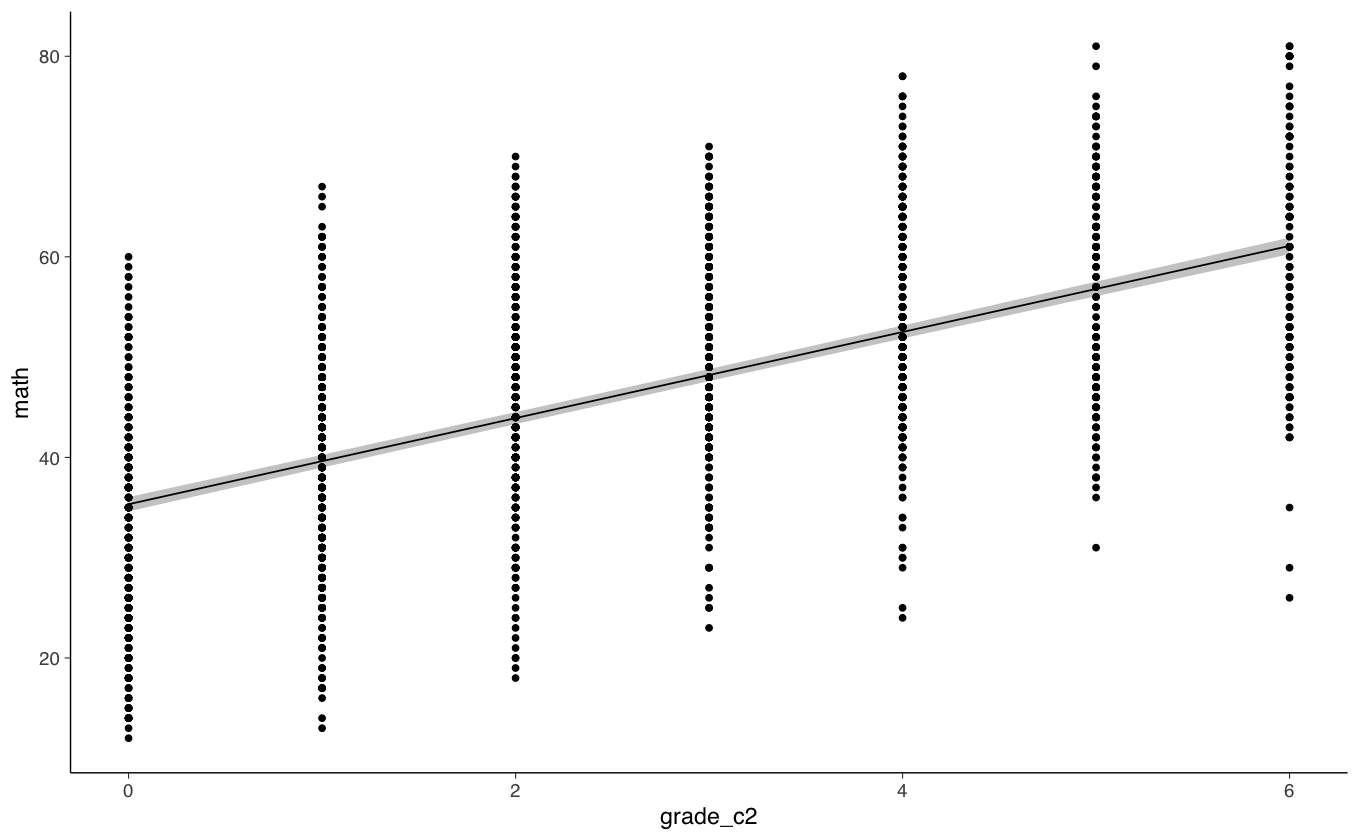

In [36]:
nlsy_math_long |>
    ggplot(aes(x= grade_c2, y= math)) +
        geom_ribbon(
            data= data.frame(emm), 
            aes(ymin= lower.CL, ymax= upper.CL, y= NULL), fill= 'grey80'
        ) +
        geom_line(data= data.frame(emm), aes(y= emmean)) +
        geom_point() 

Questi risultati, ottenuti escludendo tutte le osservazioni con dati mancanti, sono comunque molto simili ai risultati ottenuti usando `lavaan` (si veda la figura con le traiettorie di crescita del modello LGM).

## Modello di Crescita Non Lineare

In alcuni casi, può essere utile esplorare la possibilità che il cambiamento osservato segua una traiettoria non lineare. Il metodo adottato per costruire un modello di crescita non lineare può essere paragonato all'utilizzo di variabili dummy in un modello di regressione lineare. Tuttavia, in questo contesto, apportiamo una modifica specifica ai carichi fattoriali associati alla variabile latente che rappresenta la pendenza.

Nel modello di crescita non lineare, fissiamo il primo carico fattoriale a 0 e l'ultimo a 1. Questa configurazione implica che il primo punto temporale rappresenta il punto di partenza, mentre l'ultimo indica la conclusione dell'intervallo temporale considerato. I carichi fattoriali intermedi, invece, non sono fissi e vengono stimati liberamente dal modello. Questa impostazione permette di interpretare la pendenza come l'entità complessiva del cambiamento che si verifica tra l'inizio e la fine dell'intervallo temporale considerato.

I carichi fattoriali che vengono stimati rappresentano la proporzione del cambiamento complessivo che si è verificato fino a quel particolare punto temporale, rispetto al cambiamento totale osservato durante l'intero intervallo. In altre parole, questi carichi fattoriali intermedi offrono una misura di quanto il cambiamento si sia sviluppato a ogni punto temporale intermedio, in rapporto al cambiamento totale che si è verificato dall'inizio alla fine del periodo considerato.

Attraverso questo approccio, il modello di crescita non lineare fornisce una comprensione più dettagliata e flessibile della dinamica del cambiamento, permettendo di catturare traiettorie che potrebbero non essere adeguatamente descritte da un modello lineare.

In [37]:
mod_nl <- "
    i =~ 1*math2 + 1*math3 + 1*math4 + 1*math5 + 1*math6 + 1*math7 + 1*math8
    s = ~ 0 * math2 + math3 + math4 + math5 + math6 + math7 + 1*math8
    math2 ~~ theta*math2
    math3 ~~ theta*math3
    math4 ~~ theta*math4
    math5 ~~ theta*math5
    math6 ~~ theta*math6
    math7 ~~ theta*math7
    math8 ~~ theta*math8
"

Adattiamo il modello ai dati.

In [38]:
fit_nl <- growth(
  mod_nl,
  data = nlsy_math_wide, 
  estimator = "ML",
  missing = "fiml"
)

Warning message in lav_data_full(data = data, group = group, cluster = cluster, :
“lavaan WARNING: some cases are empty and will be ignored:
  741”


Warning message in lav_data_full(data = data, group = group, cluster = cluster, :
“lavaan WARNING:
    due to missing values, some pairwise combinations have less than
    10% coverage; use lavInspect(fit, "coverage") to investigate.”


Warning message in lav_mvnorm_missing_h1_estimate_moments(Y = X[[g]], wt = WT[[g]], :
“lavaan WARNING:
    Maximum number of iterations reached when computing the sample
    moments using EM; use the em.h1.iter.max= argument to increase the
    number of iterations”


Esaminiamo la soluzione.

In [39]:
summary(fit_nl, fit.measures = TRUE, standardized = TRUE) |>
    print()

lavaan 0.6.17 ended normally after 100 iterations

  Estimator                                         ML
  Optimization method                           NLMINB
  Number of model parameters                        17
  Number of equality constraints                     6

                                                  Used       Total
  Number of observations                           932         933
  Number of missing patterns                        60            

Model Test User Model:
                                                      
  Test statistic                                52.947
  Degrees of freedom                                24
  P-value (Chi-square)                           0.001

Model Test Baseline Model:

  Test statistic                               862.334
  Degrees of freedom                                21
  P-value                                        0.000

User Model versus Baseline Model:

  Comparative Fit Index (CFI)                    0.96

Effettuiamo il test del rapporto di verosimiglianze per confrontare il modello di crescita lineare con quello che assume una crescita non lineare.

In [40]:
lavTestLRT(fit_m1, fit_nl) |>
    print()


Chi-Squared Difference Test

       Df   AIC   BIC   Chisq Chisq diff   RMSEA Df diff Pr(>Chisq)    
fit_nl 24 15808 15861  52.947                                          
fit_m1 29 15949 15978 204.484     151.54 0.17733       5  < 2.2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


Il risultato indica che il modello che assume un cambiamento non lineare si adatta meglio ai dati. Possiamo visualizzare il cambiamento nel modo seguente.

In [41]:
# extract just th eloadings of the slopes
loadings <- parameterestimates(fit_nl) %>% # get estimates
  filter(lhs == "s", op == "=~") %>% # filter the rows we want
  .[["est"]] # extract "est" variable
# print result
print(loadings)

[1] 0.0000000 0.2946469 0.5331543 0.6640286 0.7992432 0.9012768 1.0000000


In [42]:
# predict scores
pred_lgm3 <- predict(fit_nl)
# create long data for each individual
pred_lgm3_long <- map(loadings, # loop over time
                      function(x) pred_lgm3[, 1] + 
                        x * pred_lgm3[, 2]) %>% 
  reduce(cbind) %>% # bring together the wave predictions 
  as.data.frame()

Warning message:
“Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead.”


Warning message:
“Removed 7 rows containing non-finite values (`stat_summary()`).”


Warning message:
“Removed 7 rows containing non-finite values (`stat_summary()`).”


Warning message:
“Removed 7 rows containing non-finite values (`stat_summary()`).”


Warning message:
“Removed 7 rows containing missing values (`geom_line()`).”


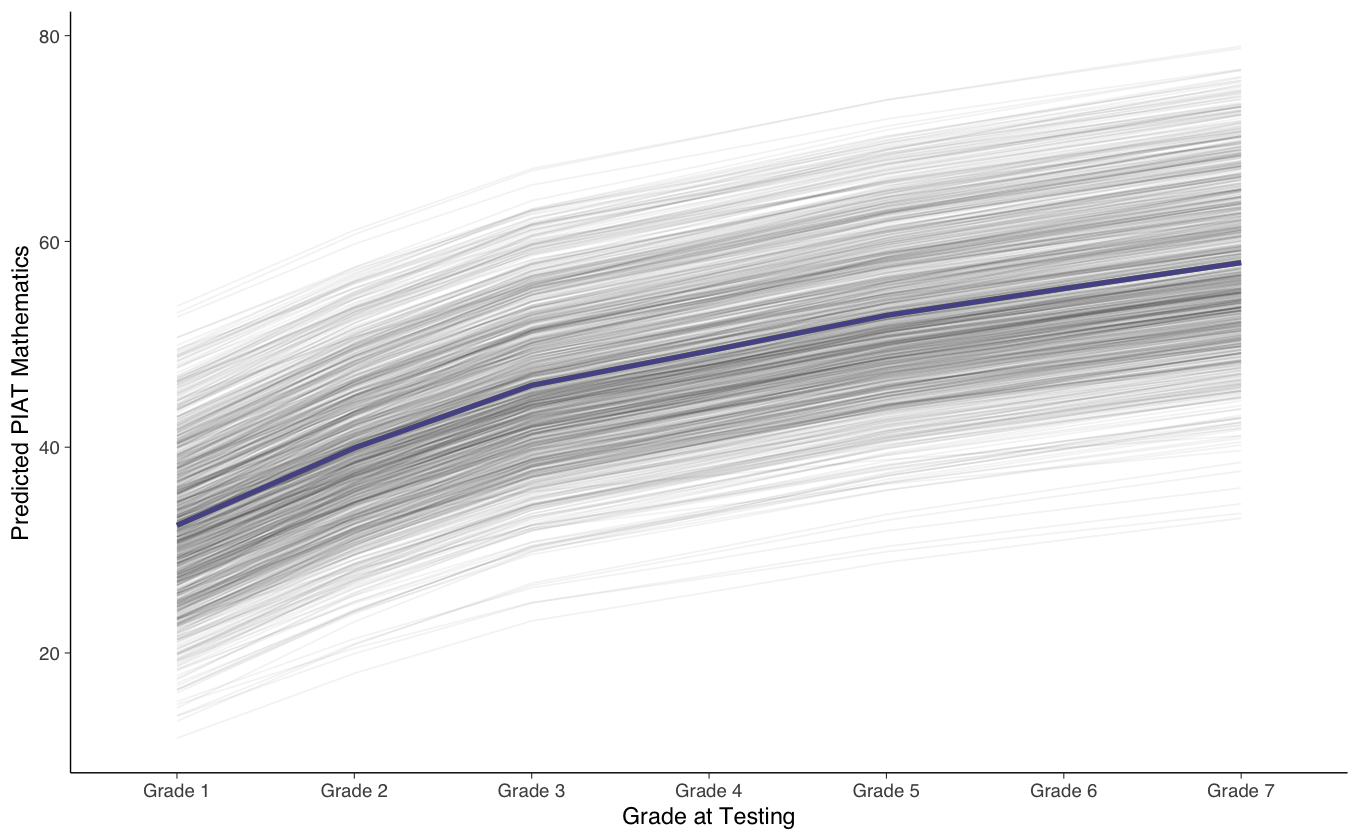

In [43]:
# predict scores
pred_lgm3 <- predict(fit_nl)
# create long data for each individual
pred_lgm3_long <- map(loadings, # loop over time
                      function(x) pred_lgm3[, 1] + 
                        x * pred_lgm3[, 2]) %>% 
  reduce(cbind) %>% # bring together the wave predictions 
  as.data.frame() %>% # make data frame
  setNames(str_c("Grade ", 1:7)) %>% # give names to variables
  mutate(id = row_number()) %>% # make unique id
  gather(-id, key = grade, value = pred) # make long format
pred_lgm3_long %>% 
  ggplot(aes(grade, pred, group = id)) + # what variables to plot?
  geom_line(alpha = 0.05) + # add a transparent line for each person
  stat_summary( # add average line
    aes(group = 1),
    fun = mean,
    geom = "line",
    size = 1.5,
    color = "green"
  ) + 
  stat_summary(data = pred_lgm3_long, # add average from linear model
               aes(group = 1),
               fun = mean,
               geom = "line",
               size = 1.5,
               color = "red",
               alpha = 0.5
  ) +
  stat_summary(data = pred_lgm3_long, # add average from squared model
               aes(group = 1),
               fun = mean,
               geom = "line",
               size = 1.5,
               color = "blue",
               alpha = 0.5
  ) +
  labs(y = "Predicted PIAT Mathematics", # labels
       x = "Grade at Testing")

## Riflessioni Finali sul Modello di Crescita Lineare

Questo capitolo ha esplorato l'implementazione e l'adattamento dei modelli di crescita lineare all'interno del framework della modellizzazione delle equazioni strutturali (SEM), utilizzando il pacchetto `lavaan` in R. Abbiamo illustrato come calcolare e visualizzare graficamente le traiettorie di crescita predette da questi modelli.

I modelli di crescita lineare rappresentano un punto di partenza essenziale per analizzare il cambiamento individuale nel tempo. Tuttavia, possono non essere sempre in grado di descrivere accuratamente il processo di cambiamento. Per questa ragione, è opportuno valutare anche altri modelli e, eventualmente, esaminare le variazioni tra diversi gruppi. L'impiego dei modelli di crescita all'interno dei framework SEM e dei modelli a effetti misti presenta sia vantaggi sia limitazioni. Ad esempio, i modelli SEM offrono indici di adattamento globale quali RMSEA, CFI e TLI, che non sono disponibili nell'approccio dei modelli a effetti misti, i quali si basano piuttosto su criteri come AIC e BIC e su strumenti diagnostici quali i grafici dei residui.

Un aspetto cruciale nell'adattamento dei modelli di crescita lineare è la scelta della metrica temporale. Nel nostro esempio, abbiamo utilizzato il grado scolastico come indicatore temporale, ma esistono altre opzioni possibili. Ad esempio, l'età al momento del test potrebbe essere una metrica più appropriata, in quanto potrebbe riflettere più accuratamente gli intervalli tra le misurazioni. Si deve inoltre considerare che l'utilizzo del grado scolastico può avere delle limitazioni, ad esempio in casi di studenti che ripetono o saltano un anno.

La posizione dell'intercetta può essere scelta in qualsiasi punto del continuum temporale. Nel nostro esempio, abbiamo centrato l'intercetta sulla valutazione della seconda elementare, in quanto era il primo dato disponibile. Tuttavia, è importante selezionare un punto di origine che sia significativo per lo studio specifico. Per esempio, posizionare l'intercetta alla fine dell'ottava elementare potrebbe essere rilevante per studi che mirano a valutare la preparazione degli studenti per la scuola superiore.


